# Loading Kaggle Dataset

In [ ]:
import os
import json

# Create the directory
os.makedirs('/root/.kaggle', exist_ok=True)

# Create kaggle.json with your credentials
kaggle_credentials = {
    "username": "ibrahim2750mi",
    "key": "KGAT_974c05bc1aeca3861b2e64909cb5a860"
}

with open('/root/.kaggle/kaggle.json', 'w') as f:
    json.dump(kaggle_credentials, f)

In [ ]:
# Set permissions
!chmod 600 /root/.kaggle/kaggle.json

# Test
!kaggle datasets list

ref                                                           title                                                size  lastUpdated                 downloadCount  voteCount  usabilityRating  
------------------------------------------------------------  ---------------------------------------------  ----------  --------------------------  -------------  ---------  ---------------  
wardabilal/spotify-global-music-dataset-20092025              Spotify Global Music Dataset (2009–2025)          1289021  2025-11-11 09:43:05.933000          15122        346  1.0              
ajinkyachintawar/sales-and-customer-behaviour-insights        Sales & Customer Behaviour Insights                 57108  2025-12-13 09:22:09.340000            763         29  1.0              
kundanbedmutha/exam-score-prediction-dataset                  Exam Score Prediction Dataset                      325454  2025-11-28 07:29:01.047000           4831         93  1.0              
kundanbedmutha/student-performance-

In [ ]:
!kaggle datasets download -d "imsparsh/deam-mediaeval-dataset-emotional-analysis-in-music"

Dataset URL: https://www.kaggle.com/datasets/imsparsh/deam-mediaeval-dataset-emotional-analysis-in-music
License(s): CC-BY-NC-SA-4.0
 99% 1.82G/1.83G [00:16<00:00, 244MB/s]
100% 1.83G/1.83G [00:16<00:00, 121MB/s]


In [ ]:
!unzip "deam-mediaeval-dataset-emotional-analysis-in-music.zip"

Streaming output truncated to the last 5000 lines.
  inflating: DEAM_Annotations/annotations/annotations per each rater/dynamic (per second annotations)/valence/137.csv  
  inflating: DEAM_Annotations/annotations/annotations per each rater/dynamic (per second annotations)/valence/1370.csv  
  inflating: DEAM_Annotations/annotations/annotations per each rater/dynamic (per second annotations)/valence/1371.csv  
  inflating: DEAM_Annotations/annotations/annotations per each rater/dynamic (per second annotations)/valence/1372.csv  
  inflating: DEAM_Annotations/annotations/annotations per each rater/dynamic (per second annotations)/valence/1373.csv  
  inflating: DEAM_Annotations/annotations/annotations per each rater/dynamic (per second annotations)/valence/1374.csv  
  inflating: DEAM_Annotations/annotations/annotations per each rater/dynamic (per second annotations)/valence/1375.csv  
  inflating: DEAM_Annotations/annotations/annotations per each rater/dynamic (per second annotations)/v

# Data Wrangling.

##  Loading annotations

In [ ]:
!pip install pandas

In [ ]:
# load data

import pandas as pd
from pathlib import Path

BASE_PATH = Path("/content/DEAM_Annotations/annotations/annotations averaged per song/dynamic (per second annotations)")


ar_df = pd.read_csv(BASE_PATH / "arousal.csv")
vl_df = pd.read_csv(BASE_PATH / "valence.csv")

In [ ]:
ar_df.size

2207450

In [ ]:
# split the clip data in the range of 5seconds; starting from 15seconds as stated in manual

def get_train_df(nn_df):
  train_df =  pd.DataFrame()

  start = 15000
  group_ms = 5000
  step_ms = 500
  groups = 6

  for i in range(groups):
      base = start + i * group_ms
      cols = [f"sample_{base + j * step_ms}ms" for j in range(10)]  # 10 samples: 0..9
      train_df[f"arousal{i}"] = nn_df.loc[:, cols].mean(axis=1)

  return train_df.stack().reset_index(drop=True)

ar_train_df = get_train_df(ar_df)
vl_train_df = get_train_df(vl_df)



train_df = pd.concat([ar_train_df, vl_train_df], axis=1)
train_df.columns = ["arousal" , "valence"]
df_new = ar_df.loc[ar_df.index.repeat(3)].reset_index(drop=True)
train_df["song_id"] = ar_df.loc[ar_df.index.repeat(6)].reset_index(drop=True)["song_id"]
print(train_df.head(10))

    arousal   valence  song_id
0 -0.127717 -0.079395        2
1 -0.148231 -0.090885        2
2 -0.150906 -0.208805        2
3 -0.232761 -0.274265        2
4 -0.262186 -0.311079        2
5 -0.263304 -0.328635        2
6 -0.143129 -0.193373        3
7 -0.164820 -0.223547        3
8 -0.169422 -0.272134        3
9 -0.187277 -0.302753        3


In [ ]:
train_df.size/ 12

2703.0

## Loading audio files

In [ ]:
!pip install librosa

In [ ]:
import librosa
import numpy as np
from concurrent.futures import ProcessPoolExecutor, as_completed
from tqdm import tqdm

song_ids = train_df["song_id"].unique()

mel_spectrograms = []

AUDIO_PATH = Path("/content/DEAM_audio/MEMD_audio")

def process_and_save_song(song_id):
    """Process and save to disk, return count of segments saved"""
    base = 15
    clip_size = 5
    saved_count = 0

    try:
        y, sr = librosa.load(AUDIO_PATH / f"{song_id}.mp3", sr=44100, mono=True)

        for j in range(6):
            start = int((base + clip_size*j) * sr)
            end = int((base + clip_size*(j+1)) * sr)
            clip = y[start:end]

            mel_spec = librosa.feature.melspectrogram(y=clip, sr=sr, n_mels=128, fmax=8000)
            mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)

            filename = SPEC_DIR / f"song_{song_id}_seg_{j}.npy"
            np.save(filename, mel_spec_db)
            saved_count += 1

        return saved_count

    except Exception as e:
        print(f"Error processing song {song_id}: {e}")
        return 0

SPEC_DIR = Path("/content/spectrograms")
SPEC_DIR.mkdir(exist_ok=True)

with ProcessPoolExecutor(max_workers=None) as executor:
    futures = [executor.submit(process_and_save_song, song_id)
               for song_id in song_ids]

    total_saved = 0
    for future in tqdm(as_completed(futures), total=len(futures)):
        total_saved += future.result()

print(f"\nTotal spectrograms saved: {total_saved}")

100%|██████████| 1802/1802 [07:57<00:00,  3.77it/s]


Total spectrograms saved: 10812


## Split Data

In [ ]:
from sklearn.model_selection import train_test_split

unique_songs = train_df["song_id"].unique()
train_songs, val_songs = train_test_split(
    unique_songs,
    test_size=0.2,
    random_state=42
)

train_data = train_df[train_df["song_id"].isin(train_songs)]
val_data = train_df[train_df["song_id"].isin(val_songs)]


## Making PyTorch Dataset

In [29]:
from torch.utils.data import Dataset
import torch

TARGET_FRAMES = 431

class DEAMDataset(Dataset):
  def __init__(self, train_df):
    self.data = train_df

  def __len__(self):
    return len(self.data)

  def __getitem__(self, idx):
    row = self.data.iloc[idx]
    seg = idx % 6
    arousal = row["arousal"]
    valence = row["valence"]
    mel_spec = np.load(SPEC_DIR / f"song_{int(row["song_id"])}_seg_{seg}.npy")

    T = mel_spec.shape[1]

    if T < TARGET_FRAMES:
        pad = TARGET_FRAMES - T
        mel_spec = np.pad(
            mel_spec,
            ((0, 0), (0, pad)),
            mode="constant",
            constant_values=-80.0
        )
    else:
        mel_spec = mel_spec[:, :TARGET_FRAMES]


    mel_spec = np.expand_dims(mel_spec, axis=0)
    mel_spec = torch.FloatTensor(mel_spec)

    # mel_spec = (mel_spec + 80.0) / 80.0   # → [0, 1]

    return mel_spec, torch.FloatTensor([arousal, valence])

In [30]:
dataset = DEAMDataset(train_data)
spec, labels = dataset[0]
print(f"Spec shape: {spec.shape}")
print(f"Labels: {labels}")
print(f"Spec range: [{spec.min()}, {spec.max()}]")

Spec shape: torch.Size([1, 128, 431])
Labels: tensor([-0.1277, -0.0794])
Spec range: [-80.0, 0.0]


In [34]:
val_dataset = DEAMDataset(val_data)

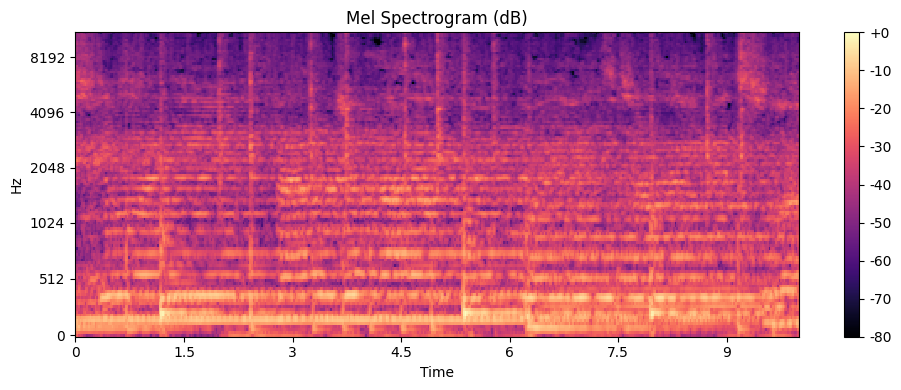

In [35]:
import matplotlib.pyplot as plt
import librosa.display

spec_np = spec.squeeze(0).cpu().numpy()

plt.figure(figsize=(10, 4))
librosa.display.specshow(
    spec_np,
    x_axis="time",
    y_axis="mel",
    cmap="magma"
)
plt.colorbar(format="%+2.0f")
plt.title("Mel Spectrogram (dB)")
plt.tight_layout()
plt.show()


In [37]:
from torch.utils.data import DataLoader

loader = DataLoader(dataset, batch_size=32, shuffle=True)
batch_spec, batch_labels = next(iter(loader))
print(f"Batch spec shape: {batch_spec.shape}")
print(f"Batch labels shape: {batch_labels.shape}")

val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

Batch spec shape: torch.Size([32, 1, 128, 431])
Batch labels shape: torch.Size([32, 2])


# CNN

In [31]:
import torch.nn as nn

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class BasicCNN(nn.Module):
    def __init__(self):
        super().__init__()

        self.net = nn.Sequential(
            nn.Conv2d(1, 16, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(16, 32, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),

            # nn.Conv2d(32, 64, 3, padding=1),
            # nn.ReLU(),
            # nn.MaxPool2d(2),

            nn.AdaptiveAvgPool2d((1, None))
        )

        self.fc = nn.Linear(32, 2)

    def forward(self, x):
      x = self.net(x)        # (B, C, 1, T)
      x = x.squeeze(2)       # (B, C, T)
      x = x.mean(dim=-1)     # (B, C)
      return self.fc(x)


## Loss and Optimizer

In [32]:
model = BasicCNN().to(device)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-2)

## Training Loop

In [40]:
best_val_loss = float('inf')

for epoch in range(50):
  # Training
  model.train()

  train_loss = 0.0

  for specs, labels in loader:
    specs, labels = specs.to(device), labels.to(device)

    preds = model(specs)
    loss = criterion(preds, labels)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    train_loss += loss.item()
  if not epoch % 3:
    print(f"Running Epoch {epoch} and Train Loss: {train_loss/len(loader)}")

Running Epoch 0 and Train Loss: 0.03980047153343354
Running Epoch 3 and Train Loss: 0.0393457138202947
Running Epoch 6 and Train Loss: 0.04009750095708124
Running Epoch 9 and Train Loss: 0.03958993183785699
Running Epoch 12 and Train Loss: 0.041336372542810175
Running Epoch 15 and Train Loss: 0.03943548441565565
Running Epoch 18 and Train Loss: 0.03940621100201158
Running Epoch 21 and Train Loss: 0.03804815089075768
Running Epoch 24 and Train Loss: 0.03993980666945561
Running Epoch 27 and Train Loss: 0.038902582738177365
Running Epoch 30 and Train Loss: 0.03749111231512689
Running Epoch 33 and Train Loss: 0.038730419347426985
Running Epoch 36 and Train Loss: 0.03789729745955485
Running Epoch 39 and Train Loss: 0.03800456588434887
Running Epoch 42 and Train Loss: 0.037460718152707795
Running Epoch 45 and Train Loss: 0.03589233351232161
Running Epoch 48 and Train Loss: 0.03631845660975059


## Validation

In [41]:
model.eval()
val_loss = 0.0
predictions = []
actuals = []


with torch.no_grad():
    for specs, labels in val_loader:
        specs, labels = specs.to(device), labels.to(device)
        preds = model(specs)
        loss = criterion(preds, labels)
        val_loss += loss.item()
        predictions.extend(preds.cpu().numpy())
        actuals.extend(labels.cpu().numpy())

print(f"Epoch {epoch}: "
      f"Val Loss: {val_loss/len(val_loader)}")

Epoch 49: Val Loss: 0.03626458335886983


## Saving the model

In [42]:
avg_val_loss = val_loss / len(val_loader)

if avg_val_loss < best_val_loss:
    best_val_loss = avg_val_loss
    torch.save(model.state_dict(), 'best_model.pt')
    print(f"Saved best model at epoch {epoch}")

Saved best model at epoch 49


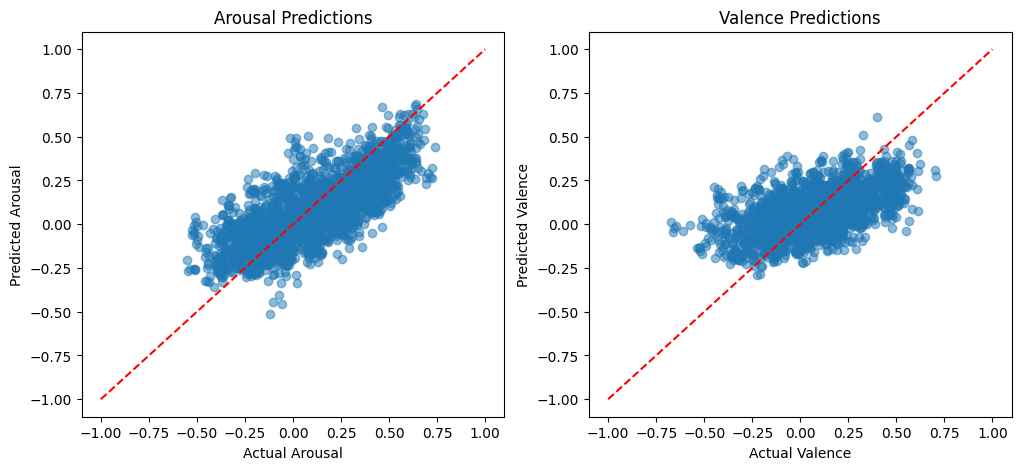

In [43]:
predictions = np.array(predictions)
actuals = np.array(actuals)

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.scatter(actuals[:, 0], predictions[:, 0], alpha=0.5)
plt.plot([-1, 1], [-1, 1], 'r--')  # Perfect prediction line
plt.xlabel('Actual Arousal')
plt.ylabel('Predicted Arousal')
plt.title('Arousal Predictions')

plt.subplot(1, 2, 2)
plt.scatter(actuals[:, 1], predictions[:, 1], alpha=0.5)
plt.plot([-1, 1], [-1, 1], 'r--')
plt.xlabel('Actual Valence')
plt.ylabel('Predicted Valence')
plt.title('Valence Predictions')

plt.show()

In [ ]:
mean_vals = actuals.mean(axis=0)   # shape: (2,)
print("Mean baseline prediction:", mean_vals)
baseline_preds = np.tile(mean_vals, (actuals.shape[0], 1))
baseline_mse = np.mean((baseline_preds - actuals) ** 2)
print("Baseline MSE:", baseline_mse)
mse = np.mean((predictions - actuals) ** 2)
print("Model MSE:", mse)


Mean baseline prediction: [0.12383987 0.07644205]
Baseline MSE: 0.06585912
Model MSE: 0.036714073


In [ ]:
print(actuals.min(axis=0), actuals.max(axis=0))


[-0.5497235 -0.6744163] [0.7404 0.7075]
